In [1]:
!pip install tf-keras-vis
!pip install ipympl
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
%reload_ext autoreload
%autoreload 2
import os
from tensorflow import keras
from matplotlib import pyplot as plt
from pennylane import numpy as np
from pennylane import numpy as np
import pennylane as qml
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from datetime import datetime
from sklearn import preprocessing

from IPython.display import display
%matplotlib inline
 
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
 
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Normalize pixel values within 0 and 1
#train_images = train_images / (255)
#test_images = test_images / (255)

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)


#name of model or experiment
model_name = "Q_Model"

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_batches = 64     # Size of the batches

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


tf.config.get_visible_devices()



2024-06-09 13:11:30.261357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 13:11:31.533709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow recognized 0 GPUs


2024-06-09 13:11:34.228458: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-09 13:11:34.228501: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: e8c1f2dec0e5
2024-06-09 13:11:34.228512: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: e8c1f2dec0e5
2024-06-09 13:11:34.228718: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.15
2024-06-09 13:11:34.228746: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.54.15
2024-06-09 13:11:34.228754: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.54.15


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:


n_qubits = 4

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

dev = qml.device("default.qubit.tf", wires=n_qubits)

keras.utils.get_custom_objects().clear()

@keras.utils.register_keras_serializable(package=(model_name+"_Layer"))
class ConvQLayer(keras.layers.Layer):
    

    #replace the contents of qnode with experiment circuit
    @qml.qnode(dev, interface='tf')
    def q_node(inputs):
        inputs *= np.pi
        # Encoding of 4 classical input values
        #Further testing of the AngleEmbedding function is needed
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        # Filter from arxiv.org/abs/2308.14930

        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[0, 3])

        # Measurement producing 4 classical output values
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    def call(self, inputs):

        #14x14 flattened 2x2 squares
        get_subsections_14x14 = lambda im : tf.reshape(tf.unstack(tf.reshape(im,[14,2,14,2]), axis = 2),[14,14,4])

        #unpack 14x14 row by row
        list_squares_2x2 = lambda image_subsections: tf.reshape(tf.unstack(image_subsections, axis = 1), [196,4])


        #send 4 values to quantum function
        process_square_2x2 = lambda square_2x2 : self.q_node(square_2x2)

        #send all squares to the quantum function wrapper
        process_subsections = lambda squares: tf.vectorized_map(process_square_2x2,squares)

        #recompile the larger square
        separate_channels = lambda channel_stack: tf.reshape(channel_stack, [14,14,4])
        #each smaller square (channel) can be extracted as [:, :, channel]
        
        #apply function across batch
        preprocessing = lambda input: tf.vectorized_map(
            lambda image:(separate_channels(tf.transpose(process_subsections(list_squares_2x2(get_subsections_14x14(image)))))),
            input
        )

        return preprocessing(inputs)*-1

qlayer = ConvQLayer()


#wrap preprocessing in model

@keras.utils.register_keras_serializable(package=(model_name+"_Pre_Model"))
def Pre_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Rescaling(scale=1./255.0),
        qlayer,
        keras.layers.Rescaling(scale=127.5, offset=127.5)
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model
pre_model = Pre_Model()

#core model

@keras.utils.register_keras_serializable(package=(model_name+"_Core_Model"))
def Q_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Rescaling(scale=1./127.5, offset=-1),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

q_model = Q_Model()


#preprocessing
pre_train_images = pre_model.predict(train_images,batch_size=n_batches)
pre_test_images = pre_model.predict(test_images,batch_size=n_batches)

#training
q_history = q_model.fit(
    pre_train_images,
    train_labels,
    validation_data=(pre_test_images, test_labels),
    batch_size = n_batches,
    epochs=n_epochs,
    verbose=2
)


938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Epoch 1/30
938/938 - 2s - 2ms/step - accuracy: 0.8594 - loss: 0.4851 - val_accuracy: 0.9246 - val_loss: 0.2660
Epoch 2/30
938/938 - 1s - 1ms/step - accuracy: 0.9269 - loss: 0.2529 - val_accuracy: 0.9376 - val_loss: 0.2195
Epoch 3/30
938/938 - 1s - 1ms/step - accuracy: 0.9369 - loss: 0.2164 - val_accuracy: 0.9428 - val_loss: 0.2001
Epoch 4/30
938/938 - 1s - 1ms/step - accuracy: 0.9423 - loss: 0.1972 - val_accuracy: 0.9443 - val_loss: 0.1897
Epoch 5/30
938/938 - 1s - 1ms/step - accuracy: 0.9452 - loss: 0.1850 - val_accuracy: 0.9453 - val_loss: 0.1833
Epoch 6/30
938/938 - 2s - 2ms/step - accuracy: 0.9476 - loss: 0.1764 - val_accuracy: 0.9458 - val_loss: 0.1790
Epoch 7/30
938/938 - 2s - 2ms/step - accuracy: 0.9498 - loss: 0.1700 - val_accuracy: 0.9474 - val_loss: 0.1761
Epoch 8/30
938/938 - 2s - 2ms/step - accuracy: 0.9509 - loss: 0.1649 - val_accuracy: 0.9481 - val_loss: 0.1740
Epoch 9/30
938/938 - 1s - 1

### Scaling

Activation maximization tool outputs in 0-255 range. The actual outputs of the q_layer are in the -1 to 1 range. The scaled model is used to test our max activation patterns.

In [16]:
input_model = Pre_Model()

tr4 = input_model.predict(train_images[:4],batch_size=4)

print(np.argmax(q_model.predict((tr4[:4]),batch_size=4), axis=1))

print(train_labels[:4])

full_model = keras.models.Sequential([
    input_model.layers[0],
    input_model.layers[1],
    input_model.layers[2],
    q_model.layers[0],
    q_model.layers[1],
    q_model.layers[2]
    ])

print(np.argsort(full_model.predict(train_images[:4],batch_size=4), axis=1))

print(train_labels[:4])

display(full_model.summary())




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[5 0 4 1]
[5 0 4 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[6 4 1 0 9 8 2 7 3 5]
 [1 4 8 7 3 6 9 2 5 0]
 [0 5 8 6 1 9 3 2 7 4]
 [0 6 9 4 5 7 8 3 2 1]]
[5 0 4 1]


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (4, 28, 28, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_q_layer (ConvQLayer)       │ (4, 14, 14, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (4, 14, 14, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (4, 14, 14, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (4, 784)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 10)                │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

None

### Random Seed

Starting with a random seed the inputs are adjusted and the maximization tool monitors and learns the interactions with the dense layer.

(array([307., 324., 323., 301., 338., 324., 268., 311., 324., 316.]),
 array([254.0002594 , 254.10021973, 254.20018005, 254.30014038,
        254.40010071, 254.50006104, 254.6000061 , 254.69996643,
        254.79992676, 254.89988708, 254.99984741]),
 <BarContainer object of 10 artists>)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[1 7 5 2 4 6 3 0 9 8]
 [1 7 5 2 4 6 3 0 9 8]
 [1 7 5 2 4 6 3 0 9 8]
 [1 7 5 2 4 6 3 0 9 8]]


/tmp/ipykernel_3366929/479621815.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


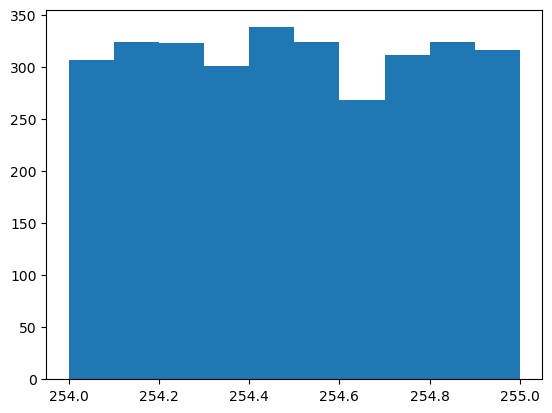

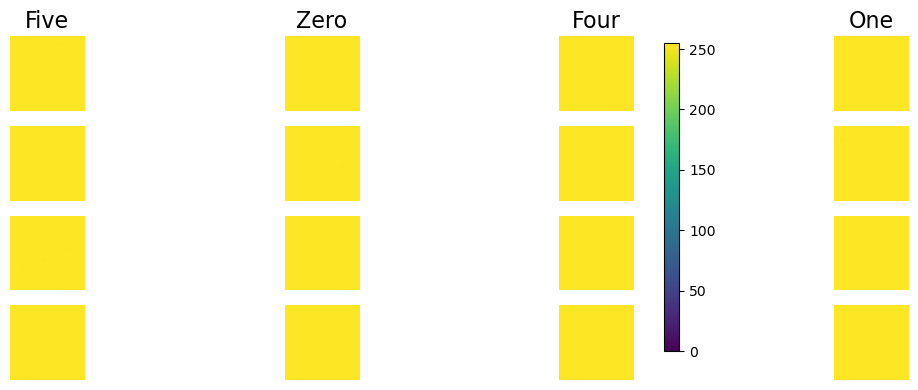

In [5]:
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear


# Create the visualization instance.
# All visualization classes accept a model and model-modifier, which, for example,
#     replaces the activation of last layer to linear function so on, in constructor.


activation_maximization = \
   ActivationMaximization(q_model,
                          model_modifier=[
                              ExtractIntermediateLayer(2),
                              ReplaceToLinear()
                             ],
                          clone=True)

#seed_input = (tf.random.uniform((4, 14, 14, 4), -50, -1) + tf.random.uniform((4, 14, 14, 4), 1, 100))*2



#np.random.poisson(255, size=(4*14*14*4))


image_titles = ['Five', 'Zero', 'Four', 'One']
scores = CategoricalScore([5, 0, 4, 1])

seed_input = tf.random.uniform((4, 14, 14, 4), 254, 255)

flat_seed = np.asarray(seed_input)

flat_seed = flat_seed.reshape([(4*14*14*4),1])

display(plt.hist(flat_seed))

print(np.argsort(q_model.predict((seed_input), batch_size=4),axis=1))

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[0, i].set_title(title, fontsize=16)
    ax[0, i].imshow(seed_input[i,:,:,0], vmin=0, vmax=255)
    ax[0, i].axis('off')
    ax[1, i].imshow(seed_input[i,:,:,1], vmin=0, vmax=255)
    ax[1, i].axis('off')
    ax[2, i].imshow(seed_input[i,:,:,2], vmin=0, vmax=255)
    ax[2, i].axis('off')
    im = ax[3, i].imshow(seed_input[i,:,:,3], vmin=0, vmax=255)
    ax[3, i].axis('off')


cbar = f.colorbar(im, ax=ax.ravel().tolist())
    
plt.tight_layout()
plt.show()

### Maximized Activation

Below are learned patterns for activating the targets [5, 0, 4, 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - Score: -1.6149 - TotalVariation2D: 0.6322 - Norm: 76.3497


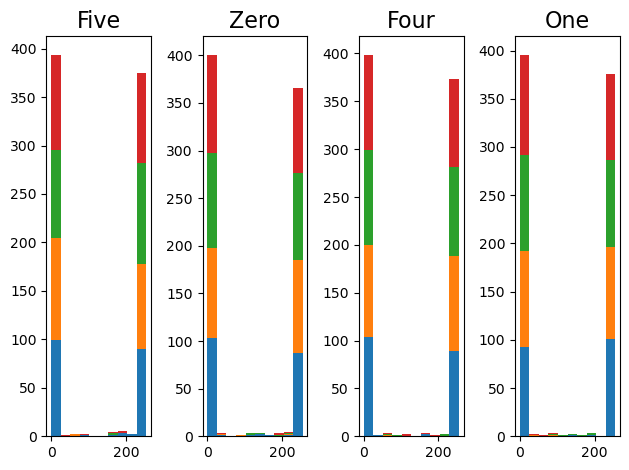

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[2 7 1 4 0 6 9 3 8 5]
 [4 3 1 7 8 9 6 5 2 0]
 [9 0 3 2 8 1 6 7 5 4]
 [8 0 3 4 5 9 6 2 7 1]]
tf.Tensor(
[[2.0539949e-32 2.4510460e-30 2.7788143e-26 3.5948770e-24 4.2440973e-24
  1.4444905e-21 1.9800866e-21 2.2816840e-21 1.3091524e-20 1.0000000e+00]
 [1.4072425e-24 2.6258390e-23 8.5488278e-22 4.0140871e-20 5.3278726e-20
  6.0337249e-20 9.3292283e-19 1.4324535e-18 3.1327311e-18 1.0000000e+00]
 [5.3684513e-20 4.4633218e-19 4.8183493e-19 7.9601622e-19 1.2939855e-18
  3.8245237e-16 5.1200045e-16 1.9678862e-15 3.5374048e-15 1.0000000e+00]
 [3.2609052e-19 6.8416491e-19 3.0819548e-16 7.3324169e-16 9.6812097e-16
  1.5772950e-15 1.6982304e-15 9.0023949e-15 2.5846012e-12 1.0000000e+00]], shape=(4, 10), dtype=float32)


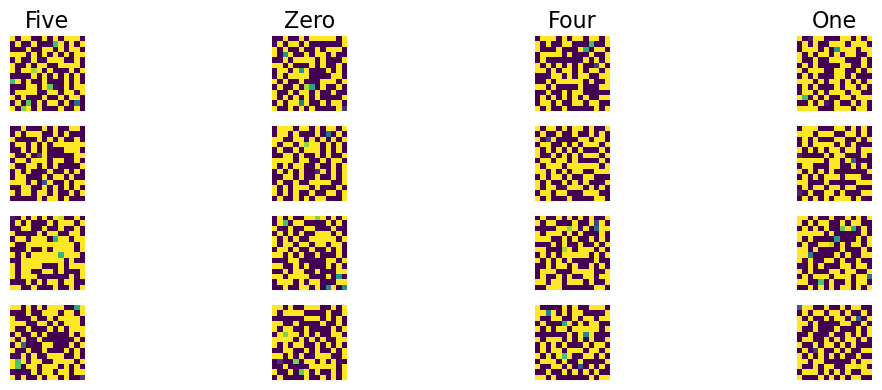

In [6]:


activations = \
   activation_maximization(scores,
                           steps=1,
                           #seed_input=tr4[:4],
                           seed_input=seed_input,
                           input_modifiers=[
                               Jitter(jitter=3),
                               #Rotate2D(degree=0.23)
                               ],
                           #regularizers=[TotalVariation2D(weight=-0.01),
                           #              Norm(weight=1, p=2)],
                           optimizer=keras.optimizers.RMSprop(255.0),
                           callbacks=[Progress()])
activations = ((np.asarray(activations)))

act_scaled = activations

act_scaled = act_scaled.reshape([4,14*14,4])


f, ax = plt.subplots(1, 4)

ax[0].set_title("Five", fontsize=16)
ax[0].hist(act_scaled[0,:,:], stacked=True)
ax[1].set_title("Zero", fontsize=16)
ax[1].hist(act_scaled[1,:,:], stacked=True)
ax[2].set_title("Four", fontsize=16)
ax[2].hist(act_scaled[2,:,:], stacked=True)
ax[3].set_title("One", fontsize=16)
ax[3].hist(act_scaled[3,:,:], stacked=True)


plt.tight_layout()
plt.show()

pred = np.asarray(q_model.predict((activations),batch_size=4))

print(np.argsort(pred,axis=1))

print(tf.sort(pred,axis=1))

act_scaled = ((np.asarray(activations)))

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[0, i].set_title(title, fontsize=16)
    ax[0, i].imshow(act_scaled[i,:,:,0])
    ax[0, i].axis('off')
    ax[1, i].imshow(act_scaled[i,:,:,1])
    ax[1, i].axis('off')
    ax[2, i].imshow(act_scaled[i,:,:,2])
    ax[2, i].axis('off')
    ax[3, i].imshow(act_scaled[i,:,:,3])
    ax[3, i].axis('off')


#cbar = f.colorbar(im, ax=ax.ravel().tolist())

plt.tight_layout()
plt.show()


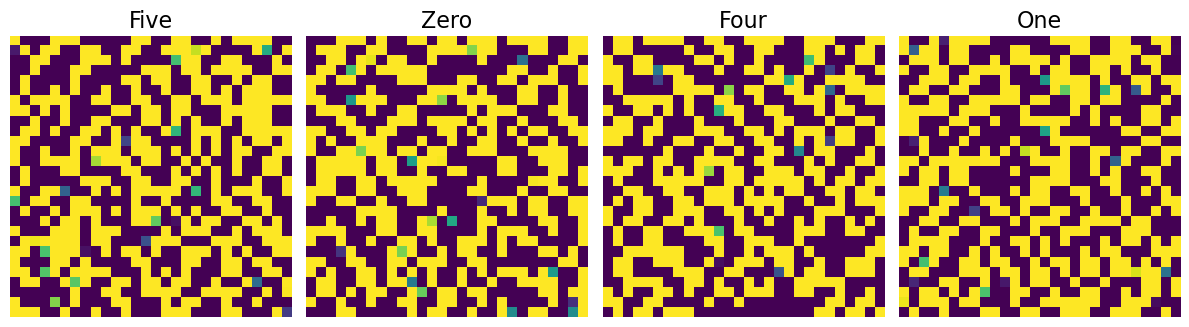

In [7]:
reassembled_pt1 = lambda square: tf.reshape(tf.vectorized_map(lambda inp: tf.transpose(inp),tf.transpose(square)),[2,14,2,14])

reassembled = lambda square: tf.reshape(tf.stack(tf.reshape(tf.stack(reassembled_pt1(square),axis=2),[2,28*14]),axis=1),[28,28])

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(reassembled(act_scaled[i,:,:,:]))
    ax[i].axis('off')


#cbar = f.colorbar(im, ax=ax.ravel().tolist())

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


<Axes: >

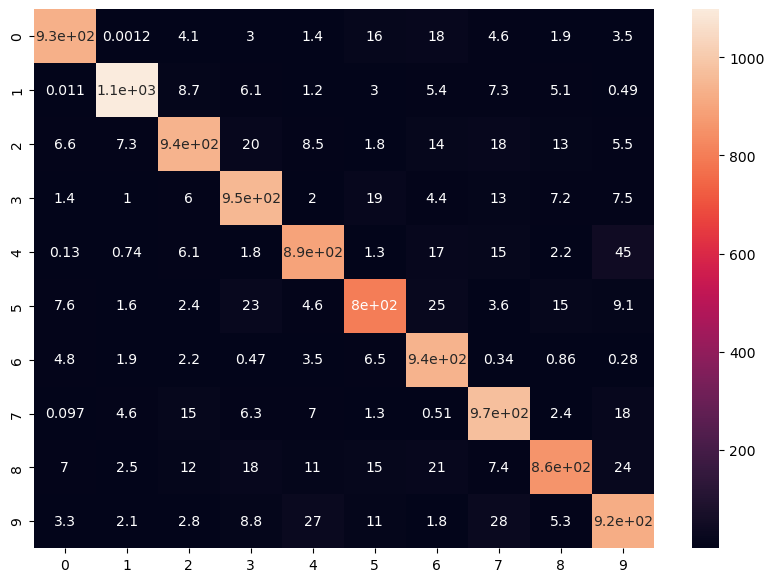

In [17]:
from sklearn.metrics import confusion_matrix

#Predict
prediction = full_model.predict(test_images)

sums = []

for num in range(10):
    sums += [np.bincount(test_labels, weights=prediction[:,num])]

sums = np.asarray(sums).T

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(sums, annot=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Score: -1.6101 - TotalVariation2D: -0.0063 - Norm: 254.4990


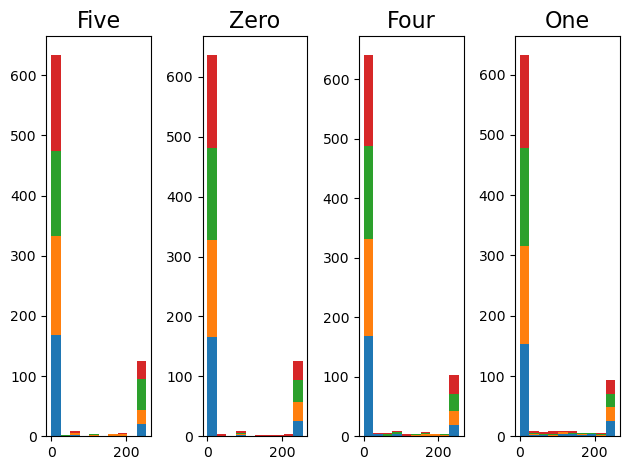

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0 1 2 3 4 6 7 9 8 5]
 [1 3 7 4 9 8 5 6 2 0]
 [0 6 3 2 9 1 8 5 7 4]
 [0 8 9 3 6 5 4 7 2 1]]
tf.Tensor(
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.64918487e-35 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.87089089e-38 9.86347165e-36 2.40898397e-35 2.42667902e-31
  1.52553080e-26 1.00000000e+00]
 [0.00000000e+00 1.84552484e-35 9.08572415e-35 1.90056039e-34
  6.89407233e-34 1.31989474e-33 1.28310910e-31 8.87337615e-31
  4.94123751e-27 1.00000000e+00]
 [0.00000000e+00 4.46651944e-36 1.10571035e-35 6.24531011e-34
  8.58400250e-34 7.82492573e-33 7.49363789e-28 2.48839490e-27
  3.48758025e-27 1.00000000e+00]], shape=(4, 10), dtype=float32)


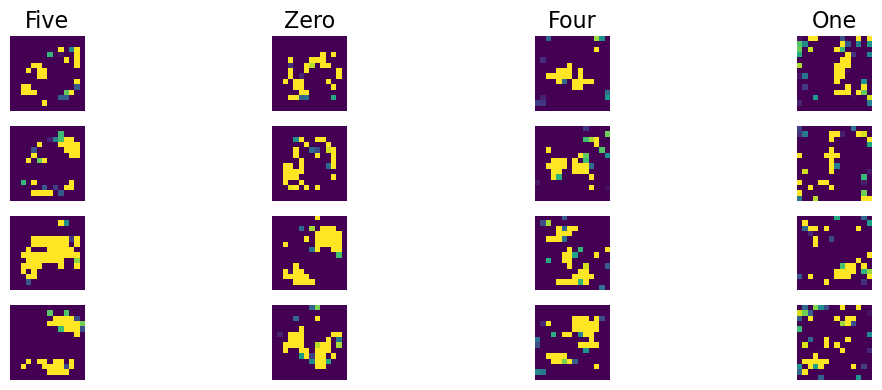

In [8]:


activations = \
   activation_maximization(scores,
                           steps=1,
                           #seed_input=tr4[:4],
                           seed_input=seed_input,
                           input_modifiers=[
                               Jitter(jitter=3),
                               #Rotate2D(degree=0.23)
                               ],
                           regularizers=[TotalVariation2D(weight=-0.01),
                                         Norm(weight=1, p=2)],
                           optimizer=keras.optimizers.RMSprop(255.0),
                           callbacks=[Progress()])
activations = ((np.asarray(activations)))

act_scaled = activations

act_scaled = act_scaled.reshape([4,14*14,4])


f, ax = plt.subplots(1, 4)

ax[0].set_title("Five", fontsize=16)
ax[0].hist(act_scaled[0,:,:], stacked=True)
ax[1].set_title("Zero", fontsize=16)
ax[1].hist(act_scaled[1,:,:], stacked=True)
ax[2].set_title("Four", fontsize=16)
ax[2].hist(act_scaled[2,:,:], stacked=True)
ax[3].set_title("One", fontsize=16)
ax[3].hist(act_scaled[3,:,:], stacked=True)


plt.tight_layout()
plt.show()

pred = np.asarray(q_model.predict((activations),batch_size=4))

print(np.argsort(pred,axis=1))

print(tf.sort(pred,axis=1))

act_scaled = ((np.asarray(activations)))

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[0, i].set_title(title, fontsize=16)
    ax[0, i].imshow(act_scaled[i,:,:,0])
    ax[0, i].axis('off')
    ax[1, i].imshow(act_scaled[i,:,:,1])
    ax[1, i].axis('off')
    ax[2, i].imshow(act_scaled[i,:,:,2])
    ax[2, i].axis('off')
    ax[3, i].imshow(act_scaled[i,:,:,3])
    ax[3, i].axis('off')


#cbar = f.colorbar(im, ax=ax.ravel().tolist())

plt.tight_layout()
plt.show()


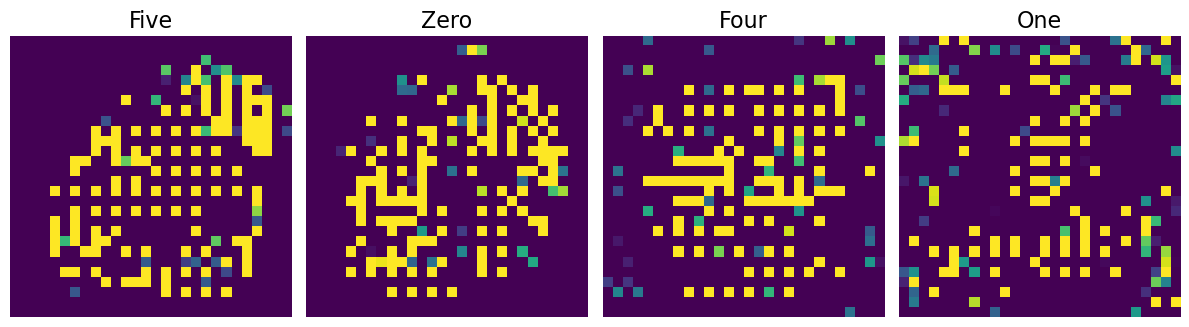

In [9]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(reassembled(act_scaled[i,:,:,:]))
    ax[i].axis('off')


#cbar = f.colorbar(im, ax=ax.ravel().tolist())

plt.tight_layout()
plt.show()

(array([340., 320., 319., 289., 310., 300., 324., 318., 287., 329.]),
 array([125.00388336, 125.40287781, 125.80187988, 126.20087433,
        126.59986877, 126.99887085, 127.3978653 , 127.79685974,
        128.19586182, 128.59484863, 128.99385071]),
 <BarContainer object of 10 artists>)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[8 1 6 4 0 7 3 2 5 9]
 [4 7 2 0 1 6 8 3 9 5]
 [6 9 8 5 4 0 2 1 3 7]
 [9 3 1 4 0 7 8 6 2 5]]


/tmp/ipykernel_3366929/1736851250.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


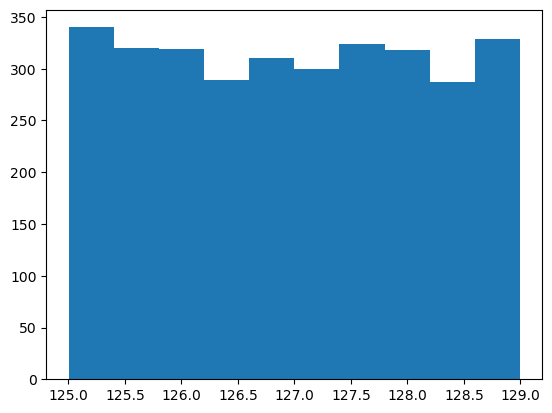

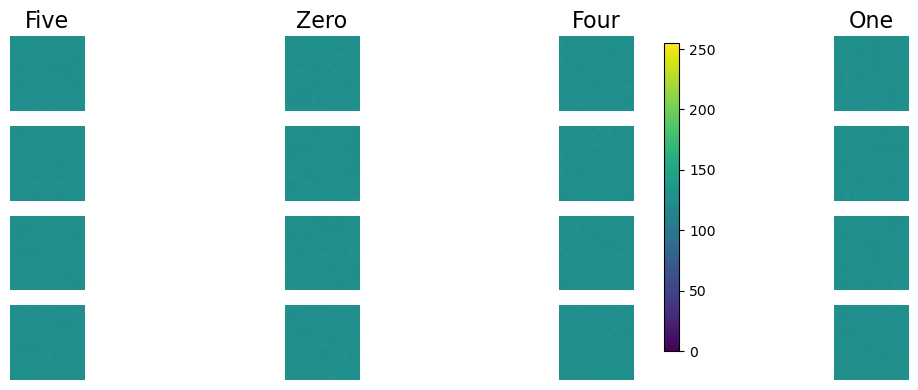

In [10]:
seed_input = tf.random.uniform((4, 14, 14, 4), 125, 129)

flat_seed = np.asarray(seed_input)

flat_seed = flat_seed.reshape([(4*14*14*4),1])

display(plt.hist(flat_seed))

print(np.argsort(q_model.predict((seed_input), batch_size=4),axis=1))

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[0, i].set_title(title, fontsize=16)
    ax[0, i].imshow(seed_input[i,:,:,0], vmin=0, vmax=255)
    ax[0, i].axis('off')
    ax[1, i].imshow(seed_input[i,:,:,1], vmin=0, vmax=255)
    ax[1, i].axis('off')
    ax[2, i].imshow(seed_input[i,:,:,2], vmin=0, vmax=255)
    ax[2, i].axis('off')
    im = ax[3, i].imshow(seed_input[i,:,:,3], vmin=0, vmax=255)
    ax[3, i].axis('off')


cbar = f.colorbar(im, ax=ax.ravel().tolist())
    
plt.tight_layout()
plt.show()

Softening the distance between the activation of the target and similar classifications approaches a diagonal pattern.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Score: -0.0215 - TotalVariation2D: -0.0289 - Norm: 12.6913


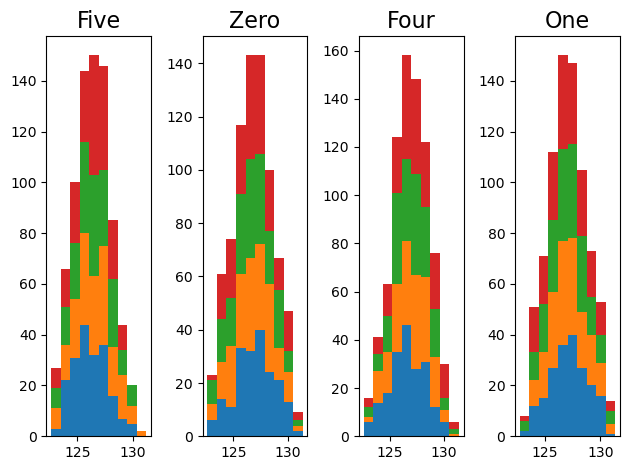

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[4 1 8 9 2 7 6 0 3 5]
 [5 3 8 1 4 9 7 6 2 0]
 [0 6 1 8 5 9 2 3 7 4]
 [0 7 6 3 9 4 8 2 5 1]]
tf.Tensor(
[[0.07727339 0.08493536 0.08687475 0.08981583 0.09869548 0.10331111
  0.10546882 0.10638463 0.11254197 0.13469873]
 [0.07185465 0.08313226 0.08510583 0.0859881  0.0864677  0.08723278
  0.09150966 0.11440837 0.11837807 0.17592266]
 [0.07964981 0.08663602 0.08723447 0.09234866 0.09783735 0.10174592
  0.10384479 0.10532068 0.10663084 0.13875146]
 [0.07835385 0.08465077 0.08607198 0.08612644 0.08947383 0.09487974
  0.10123899 0.11220121 0.123894   0.14310913]], shape=(4, 10), dtype=float32)


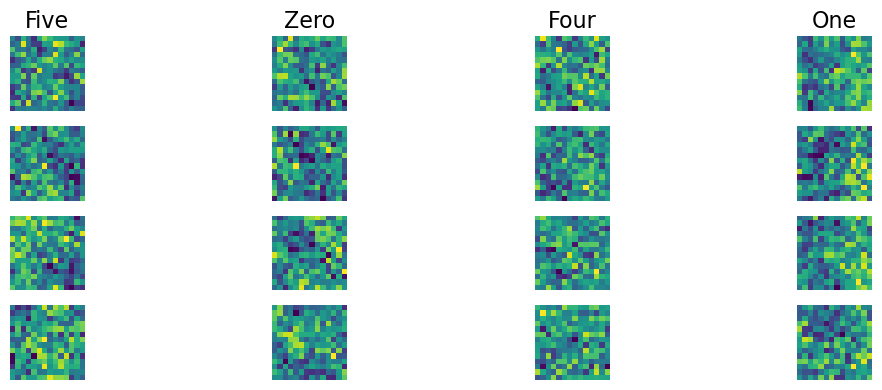

In [11]:

# You can use Score class to specify visualizing target you want.
# And add regularizers or input-modifiers as needed.
activations = \
   activation_maximization(scores,
                           steps=4,
                           #seed_input=tr4[:4],
                           seed_input=seed_input,
                           input_modifiers=[
                               Jitter(jitter=3),
                               #Rotate2D(degree=0.4264)
                               ],
                           regularizers=[TotalVariation2D(weight=-0.01),
                                         Norm(weight=0.1, p=1)],
                           optimizer=keras.optimizers.Adam(0.6),
                           callbacks=[Progress()])
activations = ((np.asarray(activations)))

act_scaled = activations

act_scaled = act_scaled.reshape([4,14*14,4])


f, ax = plt.subplots(1, 4)

ax[0].set_title("Five", fontsize=16)
ax[0].hist(act_scaled[0,:,:], stacked=True)
ax[1].set_title("Zero", fontsize=16)
ax[1].hist(act_scaled[1,:,:], stacked=True)
ax[2].set_title("Four", fontsize=16)
ax[2].hist(act_scaled[2,:,:], stacked=True)
ax[3].set_title("One", fontsize=16)
ax[3].hist(act_scaled[3,:,:], stacked=True)


plt.tight_layout()
plt.show()

pred = np.asarray(q_model.predict((activations),batch_size=4))

print(np.argsort(pred,axis=1))

print(tf.sort(pred,axis=1))

act_scaled = ((np.asarray(activations)))

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[0, i].set_title(title, fontsize=16)
    ax[0, i].imshow(act_scaled[i,:,:,0])
    ax[0, i].axis('off')
    ax[1, i].imshow(act_scaled[i,:,:,1])
    ax[1, i].axis('off')
    ax[2, i].imshow(act_scaled[i,:,:,2])
    ax[2, i].axis('off')
    ax[3, i].imshow(act_scaled[i,:,:,3])
    ax[3, i].axis('off')


#cbar = f.colorbar(im, ax=ax.ravel().tolist())

plt.tight_layout()
plt.show()

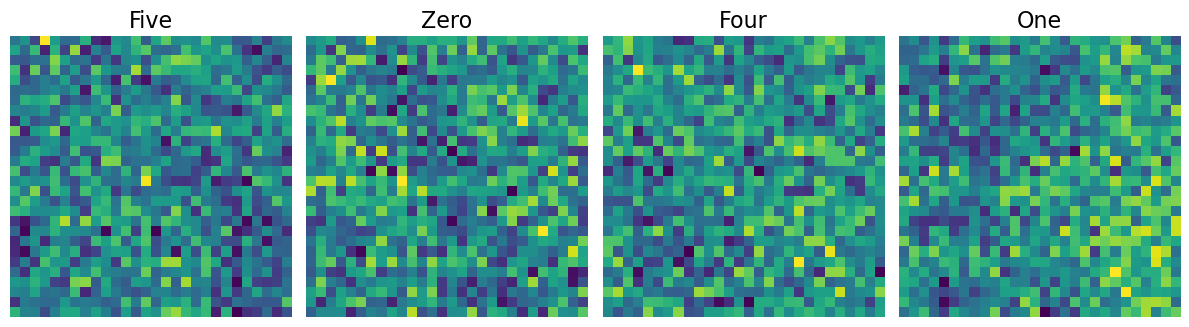

In [12]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(reassembled(act_scaled[i,:,:,:]))
    ax[i].axis('off')


#cbar = f.colorbar(im, ax=ax.ravel().tolist())

plt.tight_layout()
plt.show()

(array([[1641180.,   18949.,   14090.,   11868.,   11263.,   14451.,
           12199.,   14407.,   19490.,  202103.],
        [3282381.,   37571.,   28284.,   23564.,   22740.,   28837.,
           24433.,   28919.,   38853.,  404418.],
        [4968467.,   74032.,   56388.,   47848.,   51154.,   56550.,
           46453.,   51647.,   63967.,  463494.],
        [6609475.,  110080.,   84207.,   71726.,   78599.,   83358.,
           69666.,   77255.,   95925.,  559709.]]),
 array([122.        , 122.84999847, 123.69999695, 124.55000305,
        125.40000153, 126.25      , 127.09999847, 127.94999695,
        128.80000305, 129.6499939 , 130.5       ]),
 <a list of 4 BarContainer objects>)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


<Axes: >

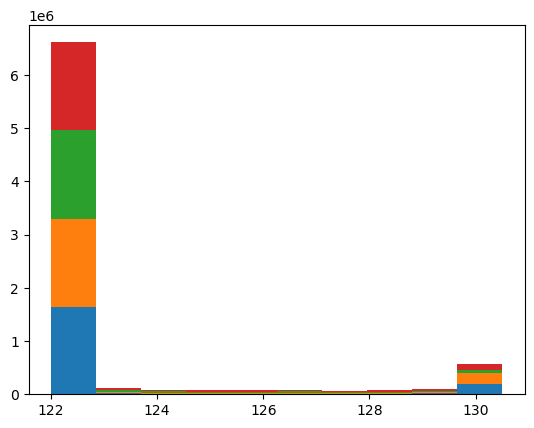

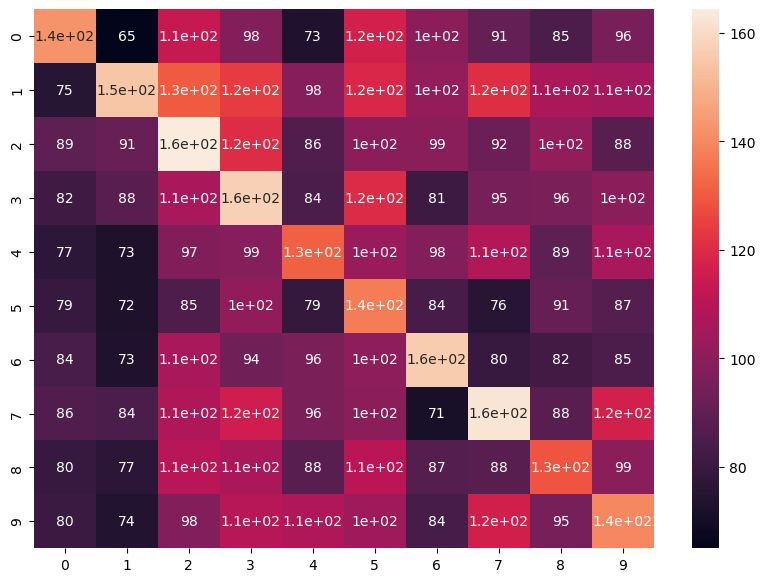

In [19]:
display(plt.hist(
    tf.transpose(tf.reshape((pre_test_images/30)+122,
                            [pre_test_images.shape[0]*pre_test_images.shape[1]*pre_test_images.shape[2],4]
                            )),stacked=True))

#Predict
prediction = q_model.predict((pre_test_images/30)+122)

sums = []

for num in range(10):
    sums += [np.bincount(test_labels, weights=prediction[:,num])]

sums = np.asarray(sums).T

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(sums, annot=True)

### Sample

Actual input sample. Helpful to review for information on distribution and shape.

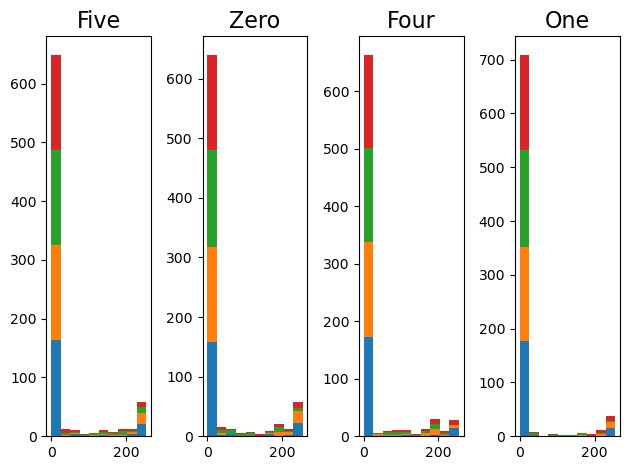

/tmp/ipykernel_3366929/740538791.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


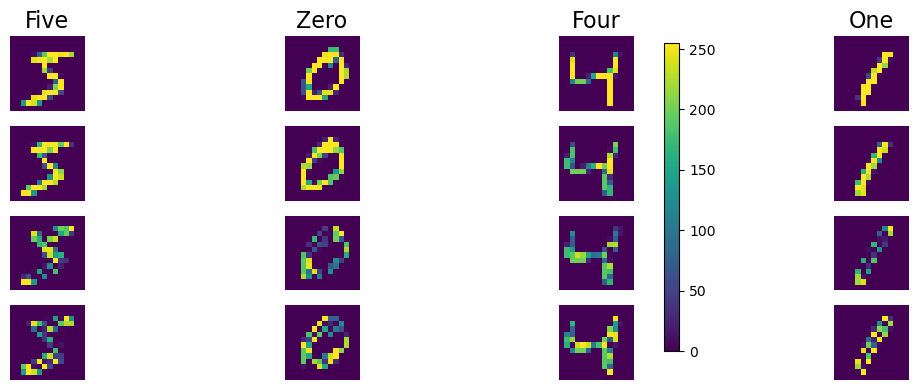

In [13]:
tr4_scaled = tr4

tr4_scaled = tr4_scaled.reshape([4,14*14,4])

f, ax = plt.subplots(1, 4)

ax[0].set_title("Five", fontsize=16)
ax[0].hist(tr4_scaled[0,:,:], stacked=True)
ax[1].set_title("Zero", fontsize=16)
ax[1].hist(tr4_scaled[1,:,:], stacked=True)
ax[2].set_title("Four", fontsize=16)
ax[2].hist(tr4_scaled[2,:,:], stacked=True)
ax[3].set_title("One", fontsize=16)
ax[3].hist(tr4_scaled[3,:,:], stacked=True)


plt.tight_layout()
plt.show()

tr4_scaled = tr4

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[0, i].set_title(title, fontsize=16)
    im = ax[0, i].imshow(tr4_scaled[i,:,:,0], vmin=0, vmax=255)
    ax[0, i].axis('off')
    ax[1, i].imshow(tr4_scaled[i,:,:,1], vmin=0, vmax=255)
    ax[1, i].axis('off')
    ax[2, i].imshow(tr4_scaled[i,:,:,2], vmin=0, vmax=255)
    ax[2, i].axis('off')
    ax[3, i].imshow(tr4_scaled[i,:,:,3], vmin=0, vmax=255)
    ax[3, i].axis('off')

cbar = f.colorbar(im, ax=ax.ravel().tolist())
    
plt.tight_layout()
plt.show()

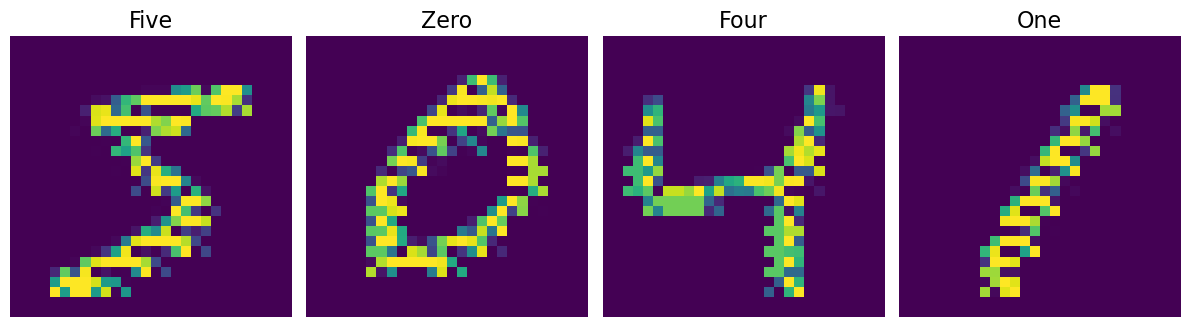

In [14]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(reassembled(tr4_scaled[i,:,:,:]))
    ax[i].axis('off')


#cbar = f.colorbar(im, ax=ax.ravel().tolist())

plt.tight_layout()
plt.show()